In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import itertools
import os
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

Считаю все маленькие фреймы в один большой

In [2]:
all_files = ['new_synsets/{}'.format(x) for x in os.listdir('new_synsets/')]
all_data = pd.read_csv(all_files[0], index_col='Unnamed: 0')
for file_name in all_files[1:]:
    new_frame = pd.read_csv(file_name, index_col='Unnamed: 0')
    all_data = all_data.append(new_frame)
all_data.shape

(339642, 3)

In [3]:
all_data.head(5)

,yarn_id,words,def_ids
0,1,машина;автомобиль;драндулет,71159;1797;39963
1,1,машина;автомашина;авто,71160;1774;1549
2,1,машина,71161
3,1,машина,71162
4,1,машина,71163


### Фильтрация

Нужно сделать существенный препроцессинг:
    * нужно избавиться от дубликатов по def_ids
    * нужно избавиться от тех синсетов, к которым нет определений, то есть проставлен NAN в def_ids
    * выбросить дубли по словам

In [4]:
# удаление строк без def_ids
synsets_with_no_definitions = all_data[all_data.def_ids.isna()]
print('Синсетов без определений: {}'.format(synsets_with_no_definitions.shape[0]))
all_data.dropna(subset=['def_ids'], inplace=True)
all_data.shape
# 339642 -312923 = 26719 без определений (но могут быть дубликаты по словам)

Синсетов без определений: 26719


(312923, 3)

In [5]:
# удаление дублей по def_ids
all_data['def_ids'] = all_data['def_ids'].apply(lambda x: str(x) if type(x) != str else x)
all_data['def_ids'] = all_data['def_ids'].apply(lambda x: ';'.join(sorted(x.split(';'))))
all_data.drop_duplicates(subset=['def_ids'], inplace=True)
all_data.shape
# 312923 - 116316 = 196607 выбросили

(116316, 3)

In [6]:
# удаление дублей по словам
all_data['words'] = all_data['words'].apply(lambda x: ';'.join(sorted(x.split(';'))))
all_data.drop_duplicates(subset=['words'], inplace=True)
all_data.shape

(75661, 3)

In [7]:
all_data.head()

,yarn_id,words,def_ids
0,1,автомобиль;драндулет;машина,1797;39963;71159
1,1,авто;автомашина;машина,1549;1774;71160
2,1,машина,71161
5,1,тачка,179054
7,1,драндулет,39962


### Первичный анализ отфильтрованных данных

<p style="color:red">Нигде далее не учитываются 26719 синсетов, к котогрым нет определений</p>

Проведем первичный анализ данных

Посчитаем длину синсетов в словах

In [8]:
all_data['length_in_words'] = all_data['words'].apply(lambda x: len(x.split(';')))
all_data['length_in_def_ids'] = all_data['def_ids'].apply(lambda x: len(x.split(';')))

In [10]:
all_data.length_in_words.describe()

count    75661.000000
mean         1.825234
std          1.125440
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         29.000000
Name: length_in_words, dtype: float64

Распределение длин синсетов в словах:

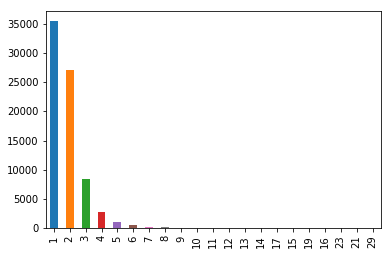

In [14]:
all_data.length_in_words.value_counts().plot.bar()

In [15]:
all_data.length_in_words.value_counts()

1     35505
2     27044
3      8369
4      2701
5      1062
6       445
7       236
8       117
9        61
10       40
11       27
12       16
13       12
14        9
17        5
15        4
19        3
16        2
23        1
21        1
29        1
Name: length_in_words, dtype: int64

Посчитаем длину синсетов в количестве определений

In [17]:
all_data.length_in_def_ids.describe()

count    75661.000000
mean         1.787896
std          1.116290
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         29.000000
Name: length_in_def_ids, dtype: float64

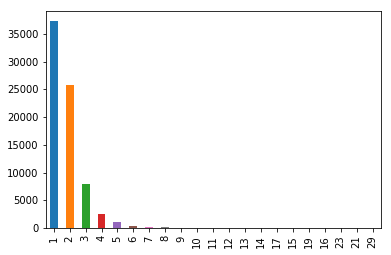

In [18]:
all_data.length_in_def_ids.value_counts().plot.bar()

In [19]:
all_data.length_in_def_ids.value_counts()

1     37333
2     25857
3      7938
4      2567
5      1019
6       431
7       225
8       116
9        55
10       39
11       28
12       16
13       11
14        9
17        5
15        4
19        3
16        2
23        1
21        1
29        1
Name: length_in_def_ids, dtype: int64

### Слияние

Слияние проводится по def_ids

Напишем функцию, которая заранее посчитает все сочетания C(k, n)
В нашем случае считаем, что k = 3, n = 75661

In [32]:
def generate_combinations(max_len, of_size):
    combinations = {}
    for i in range(1, max_len+1):
        combinations[i] = list(list(x) for x in itertools.combinations(range(0, i), of_size))
    return combinations

In [60]:
combinations = generate_combinations(max_len=29, of_size=2)

In [61]:
combinations[4]

[[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]

Сама реализация слияния:

In [62]:
indexed_synsets = {}

for _, row in all_data.iterrows():
    def_ids = np.array(row.def_ids.split(';'))
    words = set(row.words.split(';'))
    how_many_combinations_need = combinations[len(def_ids)]
    
    # в случае, если синсет порожден двумя или одним определениями
    if not how_many_combinations_need:
        indexed_synsets[row.def_ids] = [words, set(def_ids)]
        continue
        
    for combination in how_many_combinations_need:
        subset = np.sort(def_ids[combination])
        as_string = ';'.join(subset)
        if as_string in indexed_synsets:
            words_set, defs_set = indexed_synsets[as_string]
            words_set.update(words)
            defs_set.update(def_ids)
        else:
            indexed_synsets[as_string] = [set(words), set(def_ids)]

In [63]:
len(indexed_synsets)

112964

Преобразуем полученные данные в новый датафрейм, с которым можно работать и который можно анализировать

In [64]:
merged_by_triple_def_id = []
new_synset = []
new_def_ids = []

for triple in indexed_synsets:
    merged_by_triple_def_id.append(triple)
    new_synset.append(';'.join(x for x in indexed_synsets[triple][0]))
    new_def_ids.append(';'.join(x for x in indexed_synsets[triple][1]))

new_yarn = pd.DataFrame({'triple_merged_by' : merged_by_triple_def_id, 'words' : new_synset, 'def_ids' : new_def_ids})

In [74]:
new_yarn['words'] = new_yarn['words'].apply(lambda x: ';'.join(sorted(x.split(';'))))
new_yarn.drop_duplicates(subset=['words'], inplace=True)
new_yarn.shape

(72786, 5)

In [75]:
new_yarn.head()

,triple_merged_by,words,def_ids,length_in_words,length_in_def_ids
0,1797;39963,автомобиль;драндулет;машина,1797;71159;39963,3,3
2,39963;71159,автомобиль;драндулет;машина;прибор,1797;71159;39963;108163,4,4
3,1549;1774,авто;автомашина;автомобиль;кабриолет;легковая ...,148085;1774;66305;1549;71160;1797;54389;167404...,10,9
6,71161,машина,71161,1,1
7,179054,тачка,179054,1,1


### Базовый анализ после применения слияния по тройкам

In [76]:
new_yarn['length_in_words'] = new_yarn['words'].apply(lambda x: len(x.split(';')))
new_yarn['length_in_def_ids'] = new_yarn['def_ids'].apply(lambda x: len(x.split(';')))

In [77]:
new_yarn.length_in_words.describe()

count    72786.000000
mean         2.220880
std          2.489662
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         45.000000
Name: length_in_words, dtype: float64

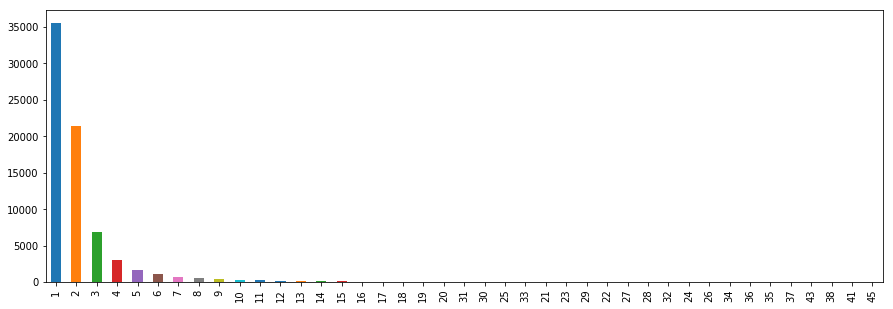

In [78]:
new_yarn.length_in_words.value_counts().plot.bar(figsize=(15, 5))

In [79]:
new_yarn.length_in_words.value_counts()

1     35505
2     21417
3      6852
4      3064
5      1701
6      1055
7       754
8       570
9       381
10      287
11      215
12      191
13      135
14      125
15       93
16       73
17       55
18       38
19       37
20       29
31       18
30       17
25       17
33       16
21       15
23       15
29       14
22       13
27       13
28       13
32       13
24       12
26        9
34        7
36        5
35        4
37        4
43        1
38        1
41        1
45        1
Name: length_in_words, dtype: int64

### Сохранение результата

In [80]:
d = new_yarn[new_yarn.length_in_words == 11]
d.shape

(215, 5)

In [81]:
d.head()

,triple_merged_by,words,def_ids,length_in_words,length_in_def_ids
273,119880;89244,доказательство;мотив;обоснование;оправдание;ос...,89244;172611;74182;84872;88145;171132;110450;1...,11,12
928,117280;84111,государство;губерния;край;круг;место;область;о...,182520;84111;145594;72008;62625;133657;63442;3...,11,11
1190,167166;167740,детка;карапуз;клоп;кроха;крошка;малолеток;малы...,36646;176255;167166;167705;69762;58479;119473;...,11,11
1223,167165;167181,капелька;капля;кроха;крохотка;крошка;крупинка;...,138486;167169;154484;166351;169422;69727;16716...,11,11
1470,67482;67508,индивид;индивидуальность;лицо;личность;особа;п...,52240;146758;52227;134327;135134;67508;178842;...,11,11


In [82]:
new_yarn.loc[1190].words

'детка;карапуз;клоп;кроха;крошка;малолеток;малыш;малышня;малютка;ребенок;ребятня'

In [83]:
new_yarn.loc[1223].words

'капелька;капля;кроха;крохотка;крошка;крупинка;крупица;малость;немного;толика;чуточка'

Отдельно сохраню данный файл, new_yarn.csv
Отдельно сохраню файл с синсетами, которые не обработались, таких 26719

In [84]:
new_yarn.to_csv('new_yarn.csv',encoding='utf-8')
synsets_with_no_definitions.to_csv('synsets_with_no_defs', encoding='utf-8')